In [2]:
# Compute RNA-Seq coverage 
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
my_file = open('/Users/hellpark/Desktop/Bioinformatics/Halomonas WT TD01.fa')
td10 = my_file.read()
td10 = td10.replace('\n','')
td10 = Seq(td10)

In [19]:
td10[0:63]
len(td10)

4188508

In [5]:
#read in and make a dataframe
df = pd.ExcelFile('/Users/hellpark/Desktop/Bioinformatics/genomic annotation of TD Chromosome-3rd seq-Version3.0.xlsx').parse('New Rank') 
df = pd.DataFrame(df, columns = ['Protein Name', 'Nucleotide', 'NaCl 60 g/L','Start','Stop', 'Together'])

In [6]:
for i in df.index:
    gene = Seq(df.at[i,'Nucleotide'])
    start = td10.find(gene)
    if start > 0:
        df.at[i,'Start'] = start
    else: df.at[i,'Start'] = td10.find(gene.reverse_complement())

In [7]:
#make stop the length of the gene
df['Stop'] = df['Start'] + len(df['Nucleotide'])

In [8]:
#sort and reindex
df = df.sort_values('Start')
df = df.reset_index(drop=True)

In [9]:
#counts up # nucleotides genes actually cover
for i in df.index:
    if i > 7:
        if df.at[i,'Start'] < df.at[i-1,'Stop']:
            df.at[i,'Together'] = df.at[i-1,'Stop']-df.at[i,'Start']
        else: df.at[i,'Together'] = df.at[i,'Stop']-df.at[i,'Start']

sum_bp = 0
for i in df.index:
    if i > 7: sum_bp += df.at[i,'Together']
print("Sum all transcriptome:", sum_bp) 
print("percent of genome: %", sum_bp/len(td10)*100)
        

Sum all transcriptome: 2881126.0
percent of genome: % 69.6462988152428


In [10]:
df[20:25]

,Protein Name,Nucleotide,NaCl 60 g/L,Start,Stop,Together
20,hypothetical protein,atgaatatgctcgtccactcccccaaaccacttatccagtttggtg...,2996,42155.0,44260.0,535.0
21,two-component sensor histidine kinase,atgagttctattcgccagcgcaccctggggcttgcgttgcttgtgt...,44,42875.0,44980.0,1385.0
22,DNA-binding response regulator,atgcgcattttactggttgaagacgacccaagcttggcatcgggga...,61,44313.0,46418.0,667.0
23,nourseothricin acetyltransferase,atgacacgtcattcttctttcggccaccgctccttagcctacacag...,151,45022.0,47127.0,1396.0
24,ATP-dependent DNA helicase Rep,atgacgccccaaccgccaaagagcattcttagccgcattaaagggc...,73,47105.0,49210.0,22.0


In [11]:
#which aren't found in the genome?
df[df['Start']==-1]

,Protein Name,Nucleotide,NaCl 60 g/L,Start,Stop,Together
0,hypothetical protein,gtgctaaacctcagtgggccgtaccccaataacgagcacgaacgtt...,1,-1.0,2104.0,NaN
1,hypothetical protein,gtgcagccaaagacagggctgcaagtggaacgcgcggtcgtgtctt...,10,-1.0,2104.0,NaN
2,hypothetical protein,atggcgcgcacgcgatccgtacaggccgctgaggcgcatttgtggc...,717,-1.0,2104.0,NaN
3,hypothetical protein,atggccatccgtaaacttagcgacctcaaacccgtgtttagcagtg...,1255,-1.0,2104.0,NaN
4,replication protein,atgcacgatgcccaaatatataaagccaatgcactgatcgaagcgt...,93,-1.0,2104.0,NaN
5,MFS transporter,gtgcaagtgcttagccgtcacccgctcgccacgattgtcatcgccc...,19,-1.0,2104.0,NaN
6,hypothetical protein,atgcaactaactattccccaagtcgcaaagctctacggaaaacacc...,424,-1.0,2104.0,NaN
7,hypothetical protein,atgtgggggctgcaccgtgcggatgtccgtaccgctgttgatcagg...,26,-1.0,2104.0,NaN


In [18]:
import matplotlib.pyplot as plt

<Figure size 432x288 with 0 Axes>

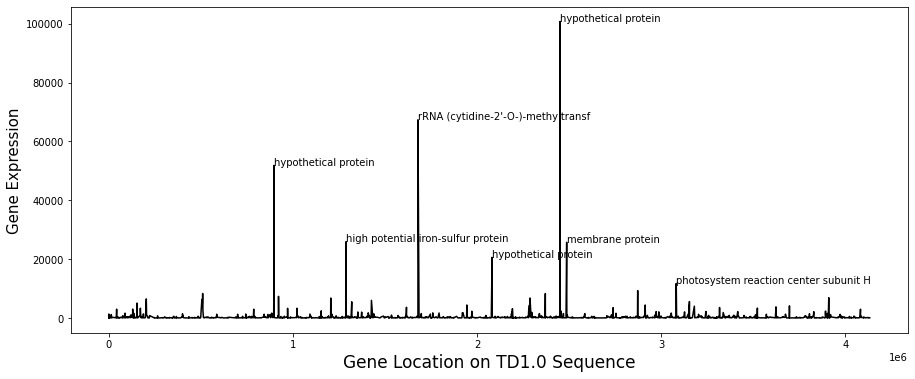

In [25]:
plt.figure()
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.set_xlabel('Gene Location on TD1.0 Sequence', size=17)
ax1.set_ylabel('Gene Expression', size=15)
x = df['Start']
activity = df['NaCl 60 g/L']
ax1.plot(x,activity,color='black',label='gene')
for i in df.index:
    if df.at[i, 'NaCl 60 g/L'] > 10000:
        ax1.annotate(df.at[i, 'Protein Name'], (df.at[i, 'Start'],df.at[i, 'NaCl 60 g/L']))
plt.show()

In [31]:
df[df['NaCl 60 g/L'] > 10000]
df.at[435, 'Nucleotide']

'gtgatgaacaaggccgcagagaaatccacccagcagtttgagtctgtctttgtatcgccaatgcgttcttataccttggcagcgcttgactactatcagcaggttgttagcgcgcaaatggatgcagcacgtgcttactcagatatgactattgcccaggcacgtacatggttagacgtgaaagatgccgacagcttcaaaaaagccatggaaagtcagcaaaaaacagcgtctgacctaatggagcgcatgaaaggagactctgaaaaagtcacctctattagccaaaactttatgcaagagagtcagaaaatggcggaagagaccactaaaaaagcagtggaaactgctaagcaataa'

In [32]:
#blast anything with very high reads
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
result_handle = NCBIWWW.qblast("blastn", "nt", df.at[435, 'Nucleotide'])
blast_record = NCBIXML.read(result_handle)

In [39]:
E_threshold = 0.01
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        if hsp.expect < E_threshold:
            print('****Alignment****')
            print('sequence:', alignment.title)
            print('length:', alignment.length)
            print('e value:', hsp.expect)
            print(hsp.query)
            print(hsp.match)
            print(hsp.sbjct)

****Alignment****
sequence: gi|1175809314|gb|CP020562.1| Halomonas sp. GT, complete genome
length: 4158464
e value: 2.9635e-155
GTGATGAACAAGGCCGCAGAGAAATCCACCCAGCAGTTTGAGTCTGTCTTTGTATCGCCAATGCGTTCTTATACCTTGGCAGCGCTTGACTACTATCAGCAGGTTGTTAGCGCGCAAATGGATGCAGCACGTGCTTACTCAGATATGACTATTGCCCAGGCACGTACATGGTTAGACGTGAAAGATGCCGACAGCTTCAAAAAAGCCATGGAAAGTCAGCAAAAAACAGCGTCTGACCTAATGGAGCGCATGAAAGGAGACTCTGAAAAAGTCACCTCTATTAGCCAAAACTTTATGCAAGAGAGTCAGAAAATGGCGGAAGAGACCACTAAAAAAGCAGTGGAAACTGCTAAGCAATAA
|||||||||||||||||||||||||| ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||| || |||||||||||||||||||||||| | ||||| || ||| | ||||| |||||||| |||||||||||||| |||||||||||||||||||||||||| |||||||||||||||||||||||||||||||||||||||||||||||||| |||||||||||||||||| |||||||||||||||||||||||||||| || ||||||||||||||||||||||| |||||||||||||| |||||||| |||
GTGATGAACAAGGCCGCAGAGAAATCTACCCAGCAGTTTGAGTCTGTCTTTGTATCGCCAATGCGTTCTTATACCTTGGCAGCGCTTGACTACTATCAGCAGGTCGTCAGCGCGCAAATGGATGCAGCACGTTCATACTCTGACATGGCA

In [91]:
df.at[1002,'Start']

1198031.0

In [37]:
blast_record.alignments.hsps[0]


AttributeError: 'list' object has no attribute 'hsps'